In [1]:
import pandas as pd
import pytrends
from pytrends.request import TrendReq
import numpy as np
import datetime
import os 
import matplotlib.pyplot as plt 
import pickle
from datetime import datetime, timedelta, date, time
import pandas as pd
from openpyxl import load_workbook
import string
import random
from copy import deepcopy
from dtaidistance import dtw
from plotly.subplots import make_subplots
import collections
import time 

from myutils import _fetch_data0

In [2]:
# Whether to crawl 3-m crawl data or read in existing ones
OVERWRITE = True

# To cluster 3-m crawl data or read in existing ones
RUN_CLUSTERING = True


In [3]:
todaydate = f'{datetime.now():%Y-%m-%d}'
savedir = os.path.join(todaydate)

In [4]:
df= pd.DataFrame({'DE': ['hotel'], 'GB': ['hotel'], 'IT': ['hotel'], 'CH': ['hotel'],
                 'CZ' : ['hotel'], 'ES' : ['hotel'], 'FR': ['hotel'], 'NL': ['hotel'], 'PL':['hotel']})
dfm = df.melt(var_name='abbr', value_name='word')

In [5]:
# Crawl (or read in existing) trends over the last 3 months 
if os.path.exists(savedir) and not OVERWRITE:
    # LOAD PREVIOUSLY CRAWLED DATA 
    data = []
    for country in dfm['abbr'].dropna().unique():
        with open(os.path.join(savedir, 'crawl_{}.p'.format(country)), 'rb') as file:
            data.append(pickle.load(file))

    # Drop duplicated cols
    data = [t.loc[:,~t.columns.duplicated()] for t in data]
    # Save crawling results full df
    df_crawl = pd.concat(data, axis=0, join='outer')
    df_crawl = df_crawl.reset_index(drop=False, level=[1])
    df_crawl.to_csv(os.path.join(savedir, 'crawl.csv'))
        
else:
    # CRAWL 3-M DATA
    os.makedirs(savedir, exist_ok=True)
    out = []
    for country in dfm['abbr'].unique():
        print(country)
        empty_words = []
        tmp = dfm[dfm['abbr'] == country]
        dataset_country = []
        for i, row in tmp.iterrows():
  
            keywords = [row['word']]
            
            pytrend = TrendReq(tz=360,backoff_factor=1)

            print(keywords)
    
            data = _fetch_data0(pytrend, 
                               kw_list=keywords, 
                               timeframe='today 3-m', 
                               cat=0, 
                               geo=country, 
                               gprop='')
            

            if not data.empty:
                data = data.drop(labels=['isPartial'],axis='columns')
                dataset_country.append(data)
            else:
                empty_words.append(row['word'])
                
        df_country = pd.concat(dataset_country, axis=1, join='inner')
        # Add columns with Nan for empty words
        df_country = pd.concat([df_country, pd.DataFrame(np.nan, index=df_country.index, 
                                                         columns=empty_words)] , axis=1)

        df_country['abbr'] = country
        df_country = df_country.set_index('abbr', append=True)
        
        # Save single country
        with open(os.path.join(savedir, 'crawl_{}.p'.format(country)), 'wb') as file:
            pickle.dump(df_country, file)
       # df_crawl = df_country.reset_index(level=1)    
    


DE
['hotel']
GB
['hotel']
IT
['hotel']
CH
['hotel']
CZ
['hotel']
ES
['hotel']
FR
['hotel']
NL
['hotel']
PL
['hotel']


In [6]:
def get_weekly_trend(trendreq, keyword:str, start:str, end:str, cat=0, 
                    geo='', gprop='', sleep=0, 
                    tz=0, verbose=False) ->pd.DataFrame:
    start_d = datetime.strptime(start, '%Y-%m-%d')
    end_d = datetime.strptime(end, '%Y-%m-%d')
    tf = start_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')
    df = _fetch_data0(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
    try:
        df.drop(columns=['isPartial'], inplace=True)
    except:
        #df = pd.DataFrame()
        print('isPartial not found ')
    return df

def get_daily_trend(trendreq, keyword:str, start:str, end:str, cat=0, 
                    geo='', gprop='', delta=269, overlap=100, sleep=0, 
                    tz=0, verbose=False) ->pd.DataFrame:

    start_d = datetime.strptime(start, '%Y-%m-%d')
    init_end_d = end_d = datetime.strptime(end, '%Y-%m-%d')
    init_end_d.replace(hour=23, minute=59, second=59)    
    delta = timedelta(days=delta)
    overlap = timedelta(days=overlap)

    itr_d = end_d - delta
    overlap_start = None

    df = pd.DataFrame()
    ol = pd.DataFrame()
    
    while end_d > start_d:
        tf = itr_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')
        if verbose: print('Fetching \''+keyword+'\' for period:'+tf)
        temp = _fetch_data0(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        if temp.empty: return pd.DataFrame() #empty timeframe -> return empty df for this word
        temp.drop(columns=['isPartial'], inplace=True)
        temp.columns.values[0] = tf
        ol_temp = temp.copy()
        ol_temp.iloc[:,:] = None
        if overlap_start is not None:  # not first iteration
            if verbose: print('Normalize by overlapping period:'+overlap_start.strftime('%Y-%m-%d'), end_d.strftime('%Y-%m-%d'))
            #normalize using the maximum value of the overlapped period
            y1 = temp.loc[overlap_start:end_d].iloc[:,0].values.max()
            y2 = df.loc[overlap_start:end_d].iloc[:,-1].values.max()
            coef = y2/y1
            temp = temp * coef
            ol_temp.loc[overlap_start:end_d, :] = 1 

        df = pd.concat([df,temp], axis=1)
        ol = pd.concat([ol, ol_temp], axis=1)
        # shift the timeframe for next iteration
        overlap_start = itr_d
        end_d -= (delta-overlap)
        itr_d -= (delta-overlap)
        # in case of short query interval getting banned by server
        time.sleep(sleep)
    
    df.sort_index(inplace=True)
    ol.sort_index(inplace=True)
    #The daily trend data is missing the most recent 3-days data, need to complete with hourly data
    if df.index.max() < init_end_d : 
        tf = 'now 7-d'
        hourly = _fetch_data0(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        if 'isPartial' not in hourly.columns:
            return pd.DataFrame()
        hourly.drop(columns=['isPartial'], inplace=True)
        
        #convert hourly data to daily data
        daily = hourly.groupby(hourly.index.date).sum()
        
        #check whether the first day data is complete (i.e. has 24 hours)
        daily['hours'] = hourly.groupby(hourly.index.date).count()
        if daily.iloc[0].loc['hours'] != 24: daily.drop(daily.index[0], inplace=True)
        daily.drop(columns='hours', inplace=True)
        
        daily.set_index(pd.DatetimeIndex(daily.index), inplace=True)
        daily.columns = [tf]
        
        ol_temp = daily.copy()
        ol_temp.iloc[:,:] = None
        # find the overlapping date
        intersect = df.index.intersection(daily.index)
        if verbose: print('Normalize by overlapping period:'+(intersect.min().strftime('%Y-%m-%d'))+' '+(intersect.max().strftime('%Y-%m-%d')))
        # scaling use the overlapped today-4 to today-7 data
        x = df.loc[intersect].iloc[:,0].max()
        y = daily.loc[intersect].iloc[:,0].max() 
        if y != 0: #catch zero division
            coef = x / y
        else:
            coef = 0
        #coef = df.loc[intersect].iloc[:,0].max() / daily.loc[intersect].iloc[:,0].max()
        daily = (daily*coef).round(decimals=0)
        ol_temp.loc[intersect,:] = 1
        
        df = pd.concat([daily, df], axis=1)
        ol = pd.concat([ol_temp, ol], axis=1)

    # taking averages for overlapped period
    df = df.mean(axis=1)
    ol = ol.max(axis=1)
    # merge the two dataframe (trend data and overlap flag)
    df = pd.concat([df,ol], axis=1)
    df.columns = [keyword,'overlap']
    # Correct the timezone difference
    df.index = df.index + timedelta(minutes=tz)
    df = df[start_d:init_end_d]
    # re-normalized to the overall maximum value to have max =100
    df[keyword] = (100*df[keyword]/df[keyword].max()).round(decimals=0)
    
    return df

In [11]:
words = df_country.columns.values

In [7]:
#  Start/End for the final crawling
start = '2018-01-11'
end = todaydate

collect_daily = {}
collect_weekly = {}


for country in df.columns: #NOTE!!!!!!!1
    print(country)
    pytrend = TrendReq(tz=360,backoff_factor=1)
    words = df_country.columns.values
    for word in words:
        overlapping = get_daily_trend(pytrend, word, start, end, geo=country, cat=0, gprop='', verbose=True)
        weekly = get_weekly_trend(pytrend, word, start, end, geo=country, cat=0, gprop='', verbose=False)
        collect_daily[word] = overlapping
        collect_weekly[word] = weekly
    print('saving country {}'.format(country))
    with open(os.path.join(savedir, '{}_daily_weekly.p'.format(country)), 'wb') as file:
        pickle.dump((collect_daily, collect_weekly), file)    
    


DE
Fetching 'hotel' for period:2020-05-16 2021-02-09
Fetching 'hotel' for period:2019-11-29 2020-08-24
Normalize by overlapping period:2020-05-16 2020-08-24
Fetching 'hotel' for period:2019-06-13 2020-03-08
Normalize by overlapping period:2019-11-29 2020-03-08
Fetching 'hotel' for period:2018-12-26 2019-09-21
Normalize by overlapping period:2019-06-13 2019-09-21
Fetching 'hotel' for period:2018-07-10 2019-04-05
Normalize by overlapping period:2018-12-26 2019-04-05
Fetching 'hotel' for period:2018-01-22 2018-10-18
Normalize by overlapping period:2018-07-10 2018-10-18
Fetching 'hotel' for period:2017-08-06 2018-05-02
Normalize by overlapping period:2018-01-22 2018-05-02
Normalize by overlapping period:2021-02-03 2021-02-06
saving country DE
GB
Fetching 'hotel' for period:2020-05-16 2021-02-09
Fetching 'hotel' for period:2019-11-29 2020-08-24
Normalize by overlapping period:2020-05-16 2020-08-24
Fetching 'hotel' for period:2019-06-13 2020-03-08
Normalize by overlapping period:2019-11-29 2

<AxesSubplot:>

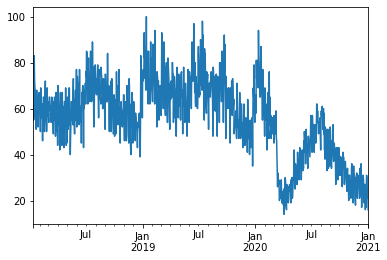

In [55]:
collect_daily['buchen']['buchen'].plot()

<AxesSubplot:>

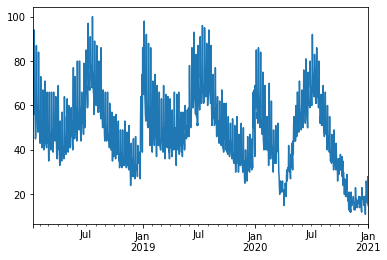

In [54]:
collect_daily['Urlaub']['Urlaub'].plot()

In [56]:
pd.concat([collect_daily[words[0]].drop(columns='overlap'), 
           collect_daily[words[1]].drop(columns='overlap')], ignore_index=True)

,buchen,Urlaub
0,62.0,NaN
1,55.0,NaN
2,57.0,NaN
3,83.0,NaN
4,73.0,NaN
...,...,...
2171,NaN,22.0
2172,NaN,18.0
2173,NaN,16.0
2174,NaN,28.0


Text(0.5, 1.0, 'daily')

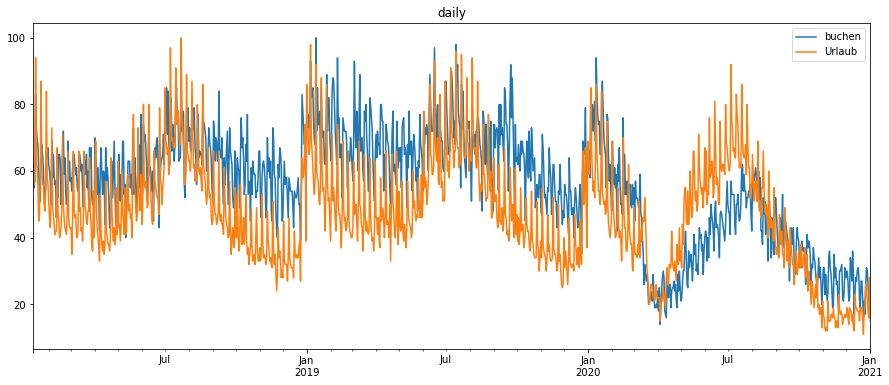

In [58]:
pd.concat([collect_daily[words[0]].drop(columns='overlap'), 
           collect_daily[words[1]].drop(columns='overlap')], axis=1).plot(figsize=(15,6))
plt.title('daily')

Text(0.5, 1.0, 'weekly')

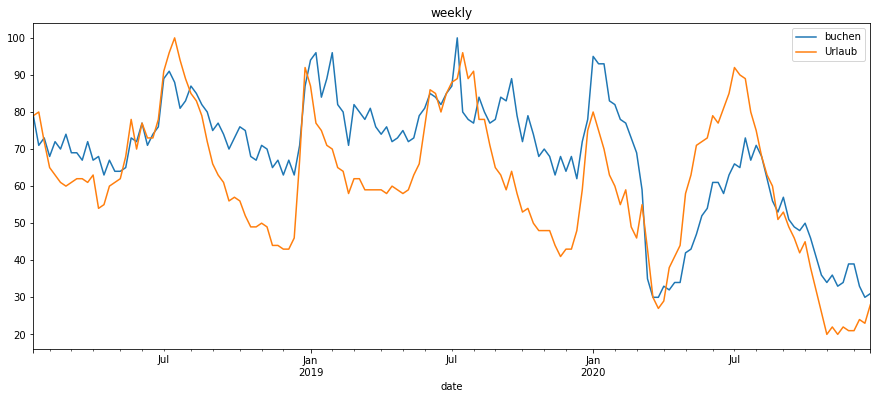

In [59]:
pd.concat([collect_weekly[words[0]], 
           collect_weekly[words[1]]], axis=1).plot(figsize=(15,6))
plt.title('weekly')

In [28]:
#COMPARE DAILY VS WEEKLY
for country in ['DE']:
    with open(os.path.join(savedir, '{}_daily_weekly.p'.format(country)), 'rb') as file:
        collect_daily, collect_weekly = pickle.load( file) 
    
    figscaler = 1 if len(clusters)>10 else 2
    figscaler = 1 if len(clusters)>10 else 2
    fig, axes = plt.subplots(ncols=1, nrows=len(words) // 2, constrained_layout=True, 
                             figsize=(15,8), sharex=True)
    for ax, cidx in zip(axes.ravel(), clusters):
        cols = dfsub[(dfsub.abbr==country) & (dfsub.cluster==cidx)]['words'].values[0]
        try:
            clust_daily = pd.concat([collect_daily[i][i] for i in cols] ,1)
        except:
            print('Daily not found')
            continue
        try:
            clust_weekly = pd.concat([collect_weekly[i][i] for i in cols] ,1)
        except:
            print('Weekly not found')
            continue
        clust_daily.mean(1).plot(ax=ax, alpha=0.7, title='cluster '+cidx, c='r', legend=True, label='daily')
        clust_weekly.mean(1).plot(ax=ax, alpha=0.7, title='cluster '+cidx, c='b',legend=True, label='weekly')

    plt.suptitle(country)
    plt.show()
#     plt.savefig(os.path.join(savedir, '{}_{}_trends_comparison.jpg'.format(country, THRESHOLD)))
#     plt.close()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1080x144 with 0 Axes>